# Setup Environment
Use validation set images from ILSVRC 2012 Challenge in a google drive folder with their labels in a meta.json. (Using validation set since no meta data available for test set)

For more information see: http://image-net.org/challenges/LSVRC/2012/

In [0]:
from google.colab import drive
from google.colab import files
from __future__ import print_function, division
import os
import json
import io
import datetime
import collections
from skimage import io
from functools import partial
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
import torchvision.models as tmodels
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader 
from torchvision.models import *

drive.mount('/content/gdrive')

In [0]:
#########################################################################################################

# replace with own directories
imagenet_validation_path = '/content/gdrive/My Drive/NI Project - RSA/RSA_on_ImageNet/selected_dataset/'
ROOT_PATH = '/content/gdrive/My Drive/NI Project - RSA/RSA_on_ImageNet/'

#########################################################################################################

# Select Data and get Metadata
Select 10 images of each of the 1000 classes of the validation data set together with their label. 

In [0]:
class ILSVRCSubDataset(Dataset):
    """ILSVRC 2012 subset of the original val dataset"""

    def __init__(self, json_file, root, transform=None):
        """
        Args:
            json_file (string): Path to the json file with meta.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.transform = transform
        # Parse META File
        with open(json_file, "r") as fd:
          self.meta = json.load(fd)
        print(self.meta)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        path = os.path.join(self.root,
                            self.meta[idx][0])
        sample = default_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
            
        wnid = self.meta[idx][1]
            
        return sample, wnid

In [0]:
data_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_val = ILSVRCSubDataset(json_file=os.path.join(imagenet_validation_path,'meta.json'),
                               root=imagenet_validation_path,
                               transform=data_transforms)

dataloaders = torch.utils.data.DataLoader(dataset_val,
                                          batch_size=20,
                                          shuffle=False)


[['ILSVRC2012_val_00000293.JPEG', 'n01440764'], ['ILSVRC2012_val_00002138.JPEG', 'n01440764'], ['ILSVRC2012_val_00003014.JPEG', 'n01440764'], ['ILSVRC2012_val_00006697.JPEG', 'n01440764'], ['ILSVRC2012_val_00007197.JPEG', 'n01440764'], ['ILSVRC2012_val_00009111.JPEG', 'n01440764'], ['ILSVRC2012_val_00009191.JPEG', 'n01440764'], ['ILSVRC2012_val_00009346.JPEG', 'n01440764'], ['ILSVRC2012_val_00009379.JPEG', 'n01440764'], ['ILSVRC2012_val_00009396.JPEG', 'n01440764'], ['ILSVRC2012_val_00000236.JPEG', 'n01443537'], ['ILSVRC2012_val_00000262.JPEG', 'n01443537'], ['ILSVRC2012_val_00000307.JPEG', 'n01443537'], ['ILSVRC2012_val_00000994.JPEG', 'n01443537'], ['ILSVRC2012_val_00002241.JPEG', 'n01443537'], ['ILSVRC2012_val_00002848.JPEG', 'n01443537'], ['ILSVRC2012_val_00003150.JPEG', 'n01443537'], ['ILSVRC2012_val_00003735.JPEG', 'n01443537'], ['ILSVRC2012_val_00004655.JPEG', 'n01443537'], ['ILSVRC2012_val_00004677.JPEG', 'n01443537'], ['ILSVRC2012_val_00002338.JPEG', 'n01484850'], ['ILSVRC2012

# Get model and activations
Use the subset with 10 images of 1000 classes on torchvisions pretrained models, get the activations of specific layer and calculate the Input RDM.

In [0]:
def getFileName(n_samples, name):
  return name \
         + "_{}_".format(n_samples) \
         + "_{}_".format(model.name) \
         + datetime.datetime.now().replace(microsecond=0).isoformat() \
         + ".npy"

In [0]:
'''
This is a complete list of models for clarity. 

In practice the notebook was run multiple times with subsets of the models.
(because Google tended to kill the instance from time to time)
'''

model_names = np.array(['resnet34', 'resnet50', 'resnext50_32x4d', 'resnext101_32x8d', 
                        'vgg13', 'vgg16', 'resnet101', 'googlenet', 'alexnet',
                        'squeezenet1_0', 'squeezenet1_1', 'mobilenet', 'vgg13_bn', 
                        'vgg11_bn', 'resnet18', 'vgg16_bn', 'vgg19_bn', 
                        'resnext101_32x8d'])

models = np.array([resnet34(pretrained=True), resnet50(pretrained=True), 
                   resnext50_32x4d(pretrained=True), resnext101_32x8d(pretrained=True), 
                   vgg13(pretrained=True), vgg16(pretrained=True), resnet101(pretrained=True), 
                   googlenet(pretrained=True), alexnet(pretrained=True), 
                   squeezenet1_0(pretrained=True), squeezenet1_1(pretrained=True),
                  mobilenet_v2(pretrained=True), vgg13_bn(pretrained=True), 
                   vgg11_bn(pretrained=True), resnet18(pretrained=True), 
                   vgg16_bn(pretrained=True), vgg19_bn(pretrained=True), 
                   resnext101_32x8d(pretrained=True)])

layer_names = np.arry(['avgpool','avgpool','avgpool','avgpool',
                      'classifier.5','classifier.5','avgpool', 'avgpool', 'classifier.5',
                      'classifier.3','classifier.3','classifier.1','classifier.5',
                      'classifier.5','avgpool','classifier.5','classifier.5',
                      'avgpool'])

In [0]:
# setup hook to catch activations of specific layer
def setup(model, layer_name, activations):
  for name, m in model.named_modules():
    # specifiy a layer name to get activations from
    if name == layer_name:
      print("register layer -> ", name)
      m.register_forward_hook(
        lambda m, i, o: activations.append(list(o.data.numpy().squeeze()))
      )

In [0]:
# calculate INPUT RDM (unoptimized)

# def correlationd_matrix(list_of_activations, n):
#      correlationd = np.zeros((n,n))
#      for i in range(n):
#          if i % 100 == 0:
#            print(i)
#          for j in range(i, n):
#              correlationd[i,j] = correlationd[j, i] = 1 - scipy.stats.pearsonr(list_of_activations[i], list_of_activations[j])[0]
#      return(correlationd)

In [0]:
# calculate INPUT RDM optimized

def correlationd_matrix(list_of_activations, n):
  def pearsonr_optimized(xm, ss_xm, ym, ss_ym):
#         x = np.asarray(x)
#         y = np.asarray(y)
#         n = len(x)
#         mx = x.mean()
#         my = y.mean()
#         xm, ym = x - mx, y - my
      r_num = np.add.reduce(xm * ym)
      r_den = np.sqrt(ss_xm * ss_ym)
      r = r_num / r_den

      # Presumably, if abs(r) > 1, then it is only some small artifact of floating
      # point arithmetic.
      r = max(min(r, 1.0), -1.0)

      return r

  #copied directly from scipy sources without change
  def ss(a, axis=0):
    def _chk_asarray(a, axis):
      if axis is None:
          a = np.ravel(a)
          outaxis = 0
      else:
          a = np.asarray(a)
          outaxis = axis

      if a.ndim == 0:
          a = np.atleast_1d(a)

      return a, outaxis

    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

  #pre-calculate necessary values
  centered_activations = np.ones(list_of_activations.shape) * -17
  centered_squared_summed_activations = np.ones((list_of_activations.shape[0],)) * -17

  for i in range(n):
    if i % 1000 == 0:
        print(i)
    centered_activations[i] = list_of_activations[i] - list_of_activations[i].mean()
    centered_squared_summed_activations[i] = ss(centered_activations[i])

  correlationd = np.zeros((n,n))
  for i in range(n):
      if i % 100 == 0:
        print(i)
      for j in range(i + 1, n):
#         correlationd[i,j] = correlationd[j, i] = 1 - scipy.stats.pearsonr(list_of_activations[i], list_of_activations[j])[0]
          correlationd[i,j] = correlationd[j, i] = 1 - pearsonr_optimized(centered_activations[i], centered_squared_summed_activations[i], centered_activations[j], centered_squared_summed_activations[j])
  return(correlationd)

In [0]:
# calculate Activations of specific layer of models (and store, if wanted) and
# calculate Input_RDM and save

data_iterator = iter(dataloaders)
NR_OF_SAMPLES = 10000
SAVE_PATH = ROOT_PATH   

for model, model_name, layer_name in zip(models, model_names, layer_name):
  print(model_name)
  #important: put model in evaluation mode for consistent results
  model.eval()
  
  activations = list()
  setup(model, layer_name, activations)
  
  # Iterator shouldn't be recreated every time, because it always returns the first element
  # Which breaks everything if shuffling is disabled
  
  for i in range(NR_OF_SAMPLES):
    print(".", end='')
    cur = next(data_iterator)[0]
    out = model(cur)
  print("\nFinished")
  print("Samples -> {}".format(len(activations)))
  print("Layer Activations -> {}".format(len(activations[0])))

  ## to save activations additionally 
  # path = os.path.join(SAVE_PATH + 'activations/', getFileName(NR_OF_SAMPLES, "activations"))
  # print("Save Activation -> {}".format(path))
  # numpy.save(path, numpy.array(activations))
  
  corr_matrix = correlationd_matrix(activations, NR_OF_SAMPLES)
  
  ## save correlation matrix = input RDM
  path = os.path.join(SAVE_PATH + 'Input_RDM/', getFileName(NR_OF_SAMPLES, "Input_RDM"))
  print("Save Input RDM -> {}".format(path))
  numpy.save(path, numpy.array(corr_matrix))

In [0]:
Input_RDM = np.load('/content/gdrive/My Drive/NI Project - RSA/RSA_on_ImageNet/activations/corrMatrix_densenet121_recalc.npy')

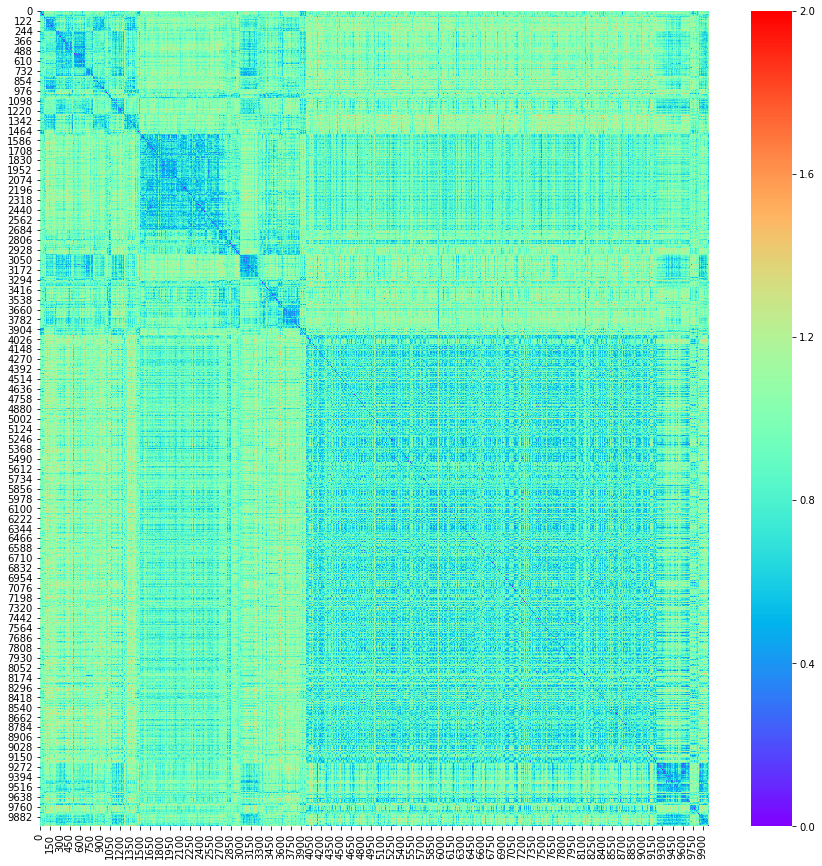

In [0]:
plt.figure(figsize=(15,15))
ax = seaborn.heatmap(Input_RDM, cmap='rainbow', vmin=0, vmax=2)